In [1]:
import os
#os.environ["JAX_CACHE_DIR"] = "/cluster/scratch/mpundir/jax-cache"

import jax
jax.config.update("jax_enable_x64", True)  # use double-precision
jax.config.update("jax_persistent_cache_min_compile_time_secs", 0)
jax.config.update("jax_platforms", "cpu")

from femsolver.quadrature import quad_tri3, shape_fn_tri3
from femsolver.operator import FemOperator
from femsolver.jax_utils import auto_vmap
import jax.numpy as jnp
import sparsediffax as sd
import numpy as np
import scipy.sparse as sp


import matplotlib.pyplot as plt
import cmcrameri.cm as cmc

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


In [2]:
# --- Mesh generation ---
def generate_unit_square_mesh_tri(nx, ny):
    x = jnp.linspace(0, 1, nx + 1)
    y = jnp.linspace(0, 1, ny + 1)
    xv, yv = jnp.meshgrid(x, y, indexing="ij")
    coords = jnp.stack([xv.ravel(), yv.ravel()], axis=-1)

    def node_id(i, j):
        return i * (ny + 1) + j

    elements = []
    for i in range(nx):
        for j in range(ny):
            n0 = node_id(i, j)
            n1 = node_id(i + 1, j)
            n2 = node_id(i, j + 1)
            n3 = node_id(i + 1, j + 1)
            elements.append([n0, n1, n3])
            elements.append([n0, n3, n2])
    return coords, jnp.array(elements)

We define a function to compute the linear elastic energy density based on the displacement gradients $\nabla u$.

$$
\Psi(x) =  \sigma(x) : \epsilon(x) 
$$

where $\sigma$ is the stress tensor and $\epsilon$ is the strain tensor.

$$
\sigma = \lambda \text{tr}(\epsilon) I + 2\mu \epsilon
$$

and 

$$
\epsilon = \frac{1}{2} (\nabla u + \nabla u^T)
$$


In [3]:
# --- Material model (linear elasticity: plane strain) ---
def compute_strain(grad_u):
    return 0.5 * (grad_u + grad_u.T)


def compute_stress(eps, mu=1.0, lmbda=1.0):
    I = jnp.eye(2)
    return 2 * mu * eps + lmbda * jnp.trace(eps) * I


def linear_elasticity_energy(grad_u, mu=1.0, lmbda=1.0):
    eps = compute_strain(grad_u)
    sigma = compute_stress(eps, mu, lmbda)
    return 0.5 * jnp.sum(sigma * eps)


The femsolver provides a generic class `FemOperator` that can be used to solve FEM problems. This operator is the core of the library as it provide functions that can automatically integrate the energy density function defined above over the range of elements.

It takes three arguments:

- `compute_quads`: a function that returns the quadrature points and weights for the elements
- `compute_shape_fn`: a function that returns the shape functions for the elements
- `compute_energy`: a function that returns the energy density for the elements


In [4]:
fem = FemOperator(quad_tri3, shape_fn_tri3, linear_elasticity_energy)

In the above definition of the ``FemOperator`` class, we have used the ``quad_tri3`` and ``shape_fn_tri3`` functions to compute the quadrature points and shape functions for the triangular elements.

One can simply replace these two functions with any other quadrature and shape function. Just look at the ``quad_tri3`` and ``shape_fn_tri3`` functions in ``femsolver/quadrature.py`` to see how to define your own.

For more complex problems, one can define their own implementation of the `FemOperator` class. One just have to inherit from the `FemOperator` class and override the functions that are needed.

For example, if we want to solve a problem with a history dependent material model, we can define a new class that inherits from the `FemOperator` class and overrides the integration functions.

```python
class HistoryDependentElasticityOperator(FemOperator):
    def integrate(self, nodal_values, nodes, history_variables):
        qp, w  = self.funcs["quads"]()

        def integrand(xi, wi, history):
            N, dNdr = self.funcs["shape_fn"](xi)
            J = dNdr @ nodes
            u_grad = self.gradient(xi, nodal_values, nodes)
            energy = self.funcs["energy"](u_grad, history)  
            return wi * energy * jnp.linalg.det(J)

        return jnp.sum(jax.vmap(integrand)(qp, w, history_variables))
```

For full implementation of such complex examples, please refere to the `examples/` directory.

Now we prepare the mesh and the boundary conditions and solve the linear elasticity problem.

In [5]:
# --- Mesh ---
coords, elements = generate_unit_square_mesh_tri(50, 50)
n_nodes = coords.shape[0]
n_dofs_per_node = 2
n_dofs = n_dofs_per_node * n_nodes
u = jnp.zeros(n_dofs)


# --- Total energy ---
def total_energy(u_flat, coords, elements, fem):
    u = u_flat.reshape(-1, n_dofs_per_node)
    u_cell = u[elements]
    x_cell = coords[elements]
    return jnp.sum(fem.integrate(u_cell, x_cell))


# creating functions to compute the gradient and 
# Hessian of the total energy using jax
grad_E = jax.grad(total_energy)
hess_E = jax.jacfwd(jax.grad(total_energy))


# creating functions to compute the gradient and 
# Hessian of the total energy using jax
grad_E = jax.grad(total_energy)
#hess_E = jax.jacfwd(jax.grad(total_energy))

In [13]:

# --- Apply Dirichlet BCs ---
left_nodes = jnp.where(jnp.isclose(coords[:, 0], 0.0))[0]
right_nodes = jnp.where(jnp.isclose(coords[:, 0], 1.0))[0]
fixed_dofs = jnp.concatenate(
    [
        2 * left_nodes,
        2 * left_nodes + 1,
        2 * right_nodes,
    ]
)
prescribed_values = jnp.zeros(n_dofs).at[2 * right_nodes].set(0.3)
free_dofs = jnp.setdiff1d(jnp.arange(n_dofs), fixed_dofs)



In [6]:
from functools import partial

In [7]:
def createSparseStructure(K, elements, nstate):
  for element in elements:
    for i in element:
      row = nstate * i
      for j in element:
        col = nstate * j
        for k in range(nstate):
          for l in range(nstate):            
            K[row + k, col + l] = 1 # we need a number to create sparse structure, later we zero it out

In [8]:
pattern = np.zeros(
    (n_dofs, n_dofs), dtype=np.int32
)
createSparseStructure(pattern, elements, n_dofs_per_node)

In [10]:
pattern_sp = jax.experimental.sparse.BCOO.fromdense(pattern)

In [9]:
grad_E_partial = partial(grad_E, coords=coords, elements=elements, fem=fem)

In [11]:
hess_E_sparse = sd.jacfwd_sparse(grad_E_partial, pattern_sp)

In [12]:
K_sparse =  hess_E_sparse(u)

In [15]:
K_sparse.data

Array([ 2. ,  0. , -0.5, ..., -1.5,  0. ,  2. ], dtype=float64)

In [16]:
K_sparse.indices

Array([[   0,    0],
       [   1,    0],
       [   2,    0],
       ...,
       [5199, 5201],
       [5200, 5201],
       [5201, 5201]], dtype=int32)

In [18]:
K_sparse @ prescribed_values

Array([0.  , 0.  , 0.  , ..., 0.  , 0.45, 0.15], dtype=float64)

In [ ]:


K = hess_E(u, coords, elements, fem)
f_int = grad_E(u, coords, elements, fem)


# --- Solve for the displacement ---
f_ext = -f_int - K @ prescribed_values
f_reduced = f_ext[free_dofs]
K_reduced = K[jnp.ix_(free_dofs, free_dofs)]
u_free = jnp.linalg.solve(K_reduced, f_reduced)
u_full = prescribed_values.at[free_dofs].set(u_free)

Now we prepare some functions to compute the stress and to plot the deformed shape with the von-mises stress.

In [19]:
# --- Compute von Mises stress ---
def von_mises_stress(stress):
    s_xx, s_yy = stress[0, 0], stress[1, 1]
    s_xy = stress[0, 1]
    return jnp.sqrt(s_xx**2 - s_xx * s_yy + s_yy**2 + 3 * s_xy**2)


# --- Compute von Mises stress per element ---
def compute_element_stress(coords, u, elements, fem):
    u_cells = u.reshape(-1,  n_dofs_per_node)[elements]
    coords_cells = coords[elements]

    def element_von_mises(u_e, x_e):
        qp, _ = quad_tri3()
        xi = qp[0]  # just take one point per element
        grad_u = fem.gradient(xi, u_e, x_e)
        eps = compute_strain(grad_u)
        sigma = compute_stress(eps)
        return von_mises_stress(sigma)

    return jax.vmap(element_von_mises)(u_cells, coords_cells)


# --- Visualization ---
from femsolver.plotting import STYLE_PATH

def plot_displacement_and_stress(coords, u, elements, stress, scale=1.0):
    displaced = coords + scale * u
    tri_elements = elements

    plt.style.use(STYLE_PATH)
    plt.figure(figsize=(5, 4))
    plt.tripcolor(
        displaced[:, 0],
        displaced[:, 1],
        tri_elements,
        facecolors=stress,
        shading="flat",
        cmap=cmc.managua_r,
        edgecolors="black",
    )
    plt.colorbar(label="Von Mises Stress")
    plt.title("Von Mises Stress on Deformed Mesh")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.axis("equal")
    plt.show()


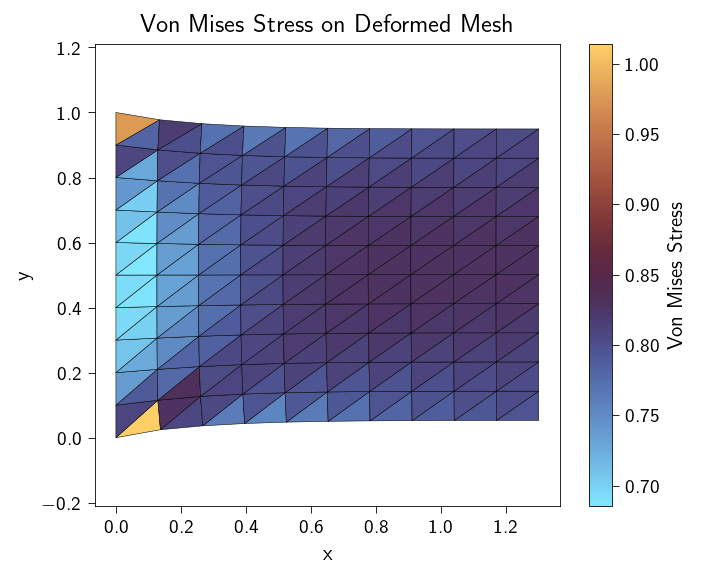

In [20]:
# --- Compute the stress ---    
u = u_full.reshape(-1, n_dofs_per_node)

stress_vm = compute_element_stress(coords, u, elements, fem)

# --- Plot the displacement and stress ---
plot_displacement_and_stress(coords, u, elements, stress_vm)